# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)
We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

## Upload helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-06-27 17:27:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.4’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-06-27 17:27:27 (16.6 MB/s) - ‘helper_functions.py.4’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys,walk_through_dir,unzip_data

## 101 Food classes : working with less data
Our goal is to beat the best original Food101 paper with 10% training data - https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-06-27 17:27:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.4’

101_food_classes_10 100%[===================>]   1.51G   197MB/s    in 16s     

2025-06-27 17:27:55 (96.4 MB/s) - ‘101_food_classes_10_percent.zip.4’ saved [1625420029/1625420029]



In [4]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/oysters'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_per

In [5]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Feature extract for 5 full passes (5 epochs on the train data and validate on 15% of the test data, to reduce time taken)

In [6]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)


In [7]:
# Data Augmentation layer
from tensorflow.keras import layers
from tensorflow.keras import Sequential
Data_Aug_layer = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # layers.Rescaling(1/255.)
],name = "data_augmentation")

## Creating the base model

In [ ]:
# 1. Create the base model with tf.keras.applicarions
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = layers.Input(shape = (224,224,3),name = "input_layer")

# 4. Give base model augmented data
x = Data_Aug_layer(inputs)

# 5. Give base model inputs
x = base_model(x,training = False)

# 6. Average Pool the outputs of the base model (aggregate all important info and reduce computations)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)

# 7. Create Output layer
outputs = layers.Dense(101,activation = "softmax",name = "output_layer")(x)

# 8. Combine inputs and outputs
model_1 = tf.keras.Model(inputs,outputs)



24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
history_1 = model_1.fit(train_data_all_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_all_10_percent),
                        validation_data = train_data_all_10_percent,
                        validation_steps = int(0.15 * len(train_data_all_10_percent)),
                        callbacks = [create_tensorboard_callback(dir_name = "Scaling_up",
                                                     experiment_name = "model_1"),
                         checkpoint_callback])

Saving TensorBoard log files to: Scaling_up/model_1/20250627-164411
Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 88s 299ms/step - accuracy: 0.1227 - loss: 4.0954 - val_accuracy: 0.4437 - val_loss: 2.5068
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 57s 241ms/step - accuracy: 0.4039 - loss: 2.6229 - val_accuracy: 0.5286 - val_loss: 1.9748
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 232ms/step - accuracy: 0.4858 - loss: 2.1902 - val_accuracy: 0.5866 - val_loss: 1.7291
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 75s 201ms/step - accuracy: 0.5316 - loss: 1.9584 - val_accuracy: 0.6036 - val_loss: 1.5534
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 187ms/step - accuracy: 0.5633 - loss: 1.8030 - val_accuracy: 0.6277 - val_loss: 1.4469


In [ ]:
model_1_result = model_1.evaluate(test_data)
model_1_result

790/790 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.5316 - loss: 1.7952


[1.655552625656128, 0.5663366317749023]

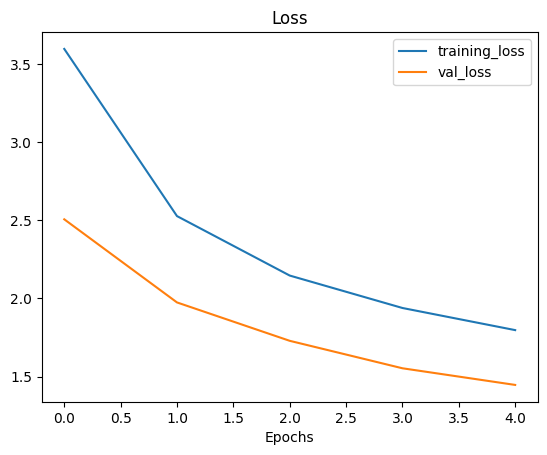

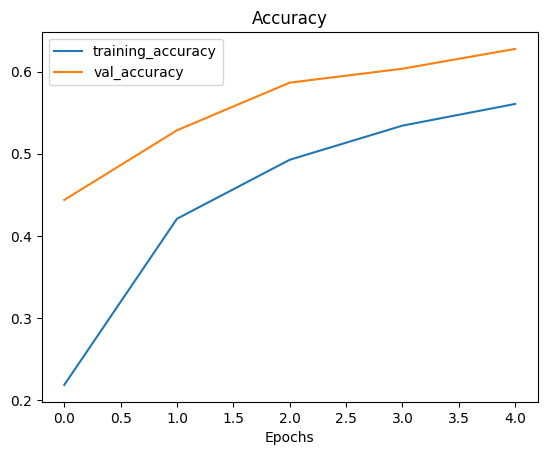

In [ ]:
plot_loss_curves(history_1)

> ** QUESTION ** - what does these curves suggest ? Hint: Ideally the 2 curves should be similar to each other , its not here ....
Ans: No problem here it is good just the model is underfitted as it was trained for only 5 epochs


## Fine tuning

In [ ]:
#Unfreeze all the layers in base model
base_model.trainable = True

#Refreeze every layer expect 5 last layers -
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower lr (prev - 0.01 now 0.001)
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ["accuracy"])

In [ ]:
for layer_no,layer in enumerate(base_model.layers):
  print(layer_no,layer,layer.trainable)

0 <InputLayer name=input_layer, built=True> False
1 <Rescaling name=rescaling, built=True> False
2 <Normalization name=normalization, built=True> False
3 <Conv2D name=stem_conv, built=True> False
4 <BatchNormalization name=stem_bn, built=True> False
5 <Activation name=stem_activation, built=True> False
6 <Conv2D name=block1a_project_conv, built=True> False
7 <BatchNormalization name=block1a_project_bn, built=True> False
8 <Activation name=block1a_project_activation, built=True> False
9 <Conv2D name=block2a_expand_conv, built=True> False
10 <BatchNormalization name=block2a_expand_bn, built=True> False
11 <Activation name=block2a_expand_activation, built=True> False
12 <Conv2D name=block2a_project_conv, built=True> False
13 <BatchNormalization name=block2a_project_bn, built=True> False
14 <Conv2D name=block2b_expand_conv, built=True> False
15 <BatchNormalization name=block2b_expand_bn, built=True> False
16 <Activation name=block2b_expand_activation, built=True> False
17 <Conv2D name=bloc

In [ ]:
for layer in model_1.layers:
  print(layer,layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=data_augmentation, built=True> True
<Functional name=efficientnetv2-b0, built=True> True
<GlobalAveragePooling2D name=pooling_layer, built=True> True
<Dense name=output_layer, built=True> True


In [ ]:
# fine_tune it for another 5 epochs
fine_tune_epoch = 10 # 5 before 5 now
# fine_tune it now
history_2 = model_1.fit(train_data_all_10_percent,
                        epochs = fine_tune_epoch,
                        validation_data = test_data,
                        validation_steps = int(0.15 * len(test_data)),
                        initial_epoch = history_1.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 62s 205ms/step - accuracy: 0.5404 - loss: 1.8954 - val_accuracy: 0.5675 - val_loss: 1.6507
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 46s 194ms/step - accuracy: 0.6269 - loss: 1.4784 - val_accuracy: 0.5596 - val_loss: 1.6777
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.6664 - loss: 1.3047 - val_accuracy: 0.5935 - val_loss: 1.5359
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - accuracy: 0.6838 - loss: 1.1874 - val_accuracy: 0.5689 - val_loss: 1.6357
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - accuracy: 0.7106 - loss: 1.0663 - val_accuracy: 0.5773 - val_loss: 1.6188
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.7422 - loss: 0.9738 - val_accuracy: 0.5855 - val_loss: 1.5945


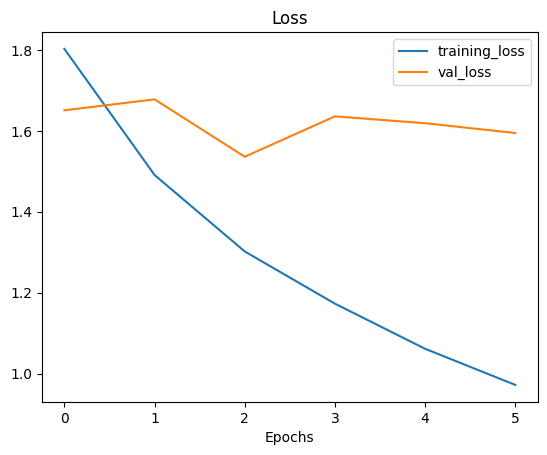

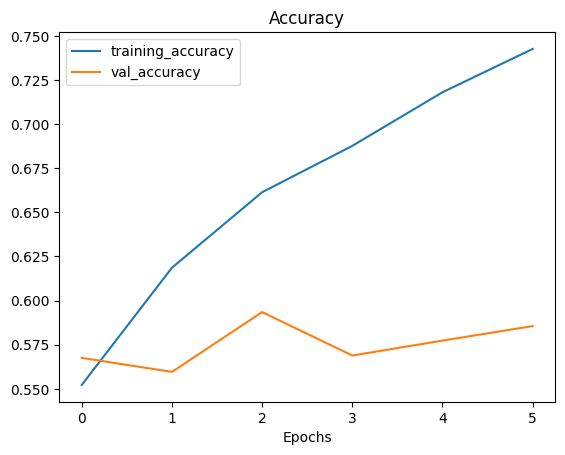

In [ ]:
plot_loss_curves(history_2)

**Note** - Model here shows sign of overfitting i.e performs well with train data and worse with test data

In [ ]:
# Evaluate our fine tuned model on whole test data
result_2 = model_1.evaluate(test_data)
result_2

790/790 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.6059 - loss: 1.5069


[1.3980443477630615, 0.6290296912193298]

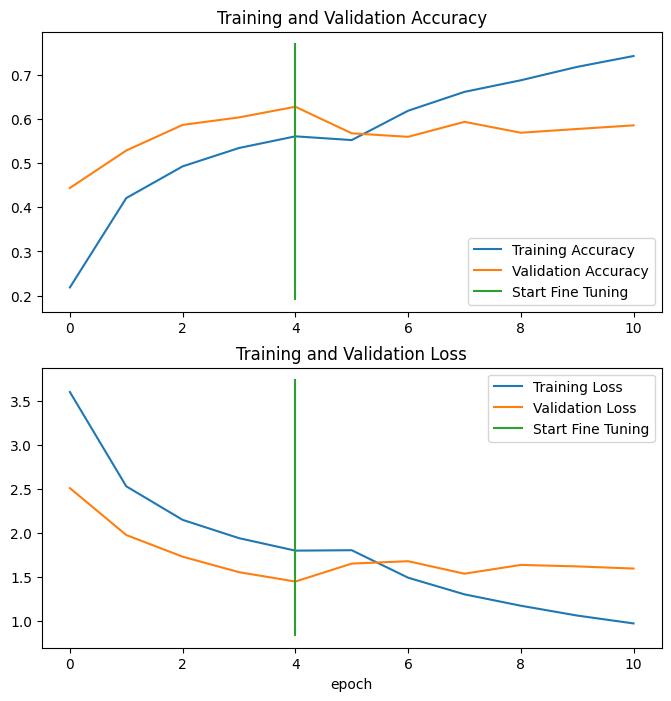

In [ ]:
# Compare histories of feauture extraction model with fine tuned model
compare_historys(original_history = history_1,
                 new_history = history_2)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [ ]:
# Save our fine-tuning model
import os
# Define the directory path
save_dir = "drive/MyDrive/Tensorflow/"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Define the full file path
save_path = os.path.join(save_dir, "model_1.keras")

# Save the model to the specified path
model_1.save(save_path)

In [6]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("drive/MyDrive/Tensorflow/model_1.keras")

In [7]:
loaded_model_res = loaded_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.6059 - loss: 1.5069


In [ ]:
loaded_model_res == result_2

True

## Evaluating the performance of the loaded model across all different classes

Let's make some predictions, visualize them and then later find out which prediction were the "most" wrong.

In [12]:
import tensorflow as tf
# Model prepared by sir so that we get very similar results
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
# Use your own model as the loading of above model is giving errors

In [13]:
loaded_model_res # Using this model

[1.3980445861816406, 0.6290296912193298]

## Making predictions with our trained model

In [8]:
# Make predictions with our model
pred_probs = loaded_model.predict(test_data,verbose = 1) # Set verbosity to see how long is left

790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step


In [13]:
len(test_data)

790

In [14]:
# How many predictions are there ?
len(pred_probs)

25250

In [15]:
# What is the shape of our predictions ?
pred_probs.shape

(25250, 101)

In [16]:
# Lets seee what the first ten predictions look like...
pred_probs[:10]

array([[1.9058581e-02, 1.1503398e-04, 2.0868418e-01, ..., 3.0074127e-06,
        1.7163659e-03, 2.9152751e-04],
       [6.1826336e-01, 3.2579178e-06, 9.3908645e-03, ..., 1.4800380e-03,
        3.9618921e-05, 3.2848198e-04],
       [4.0311348e-01, 4.7702674e-04, 9.4878025e-02, ..., 1.6288297e-03,
        3.3987086e-05, 2.4443984e-03],
       ...,
       [1.6015568e-01, 7.2104194e-07, 2.4399643e-03, ..., 1.5763416e-04,
        5.5422599e-04, 6.8078087e-05],
       [2.8795671e-01, 6.0506569e-05, 5.2338414e-02, ..., 4.8335394e-04,
        2.5980553e-05, 2.2153016e-04],
       [5.3347892e-01, 1.8223126e-06, 4.4072112e-03, ..., 4.5644795e-03,
        6.0627708e-06, 7.1194378e-04]], dtype=float32)

In [17]:
# What does the first prediction probability looks like ?
pred_probs[0],len(pred_probs[0]),sum(pred_probs[0])

(array([1.90585814e-02, 1.15033981e-04, 2.08684176e-01, 1.00130580e-06,
        1.18433760e-04, 3.32541240e-04, 1.08709000e-05, 7.46648220e-06,
        5.58290223e-04, 4.12210735e-04, 4.41707707e-05, 3.70945563e-05,
        2.85763472e-05, 8.25982424e-05, 1.18207429e-02, 1.68803576e-02,
        6.50296686e-04, 2.23310874e-03, 1.31266180e-03, 5.96056751e-04,
        8.33331328e-03, 1.53927485e-05, 9.52164919e-05, 1.24511585e-04,
        1.17265363e-03, 6.97885407e-04, 6.10148127e-04, 2.83309364e-05,
        2.91493069e-02, 1.54124762e-04, 4.30040791e-06, 1.94379390e-04,
        1.36327120e-02, 2.02390424e-04, 6.16396777e-03, 1.56103270e-04,
        7.96561770e-04, 7.92481122e-04, 3.71466577e-03, 2.69045850e-04,
        7.66962359e-04, 8.50340817e-04, 6.36033656e-05, 7.22978497e-04,
        8.25297393e-05, 6.03341672e-04, 9.39164674e-05, 3.69861838e-04,
        9.26559616e-04, 7.79338628e-02, 2.38821376e-04, 2.00371677e-03,
        2.71921754e-01, 1.22422865e-02, 1.43911702e-05, 3.757415

Our model outputs a prediction probability array (with N no of variables), where N is rhe number of classes for each sample passed to the predict method

In [18]:
# We get one prediction prob per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for one sample: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model: {pred_probs[0].argmax()}")

Number of prediction probabilities for one sample: 101
What prediction probability sample 0 looks like:
 [1.90585814e-02 1.15033981e-04 2.08684176e-01 1.00130580e-06
 1.18433760e-04 3.32541240e-04 1.08709000e-05 7.46648220e-06
 5.58290223e-04 4.12210735e-04 4.41707707e-05 3.70945563e-05
 2.85763472e-05 8.25982424e-05 1.18207429e-02 1.68803576e-02
 6.50296686e-04 2.23310874e-03 1.31266180e-03 5.96056751e-04
 8.33331328e-03 1.53927485e-05 9.52164919e-05 1.24511585e-04
 1.17265363e-03 6.97885407e-04 6.10148127e-04 2.83309364e-05
 2.91493069e-02 1.54124762e-04 4.30040791e-06 1.94379390e-04
 1.36327120e-02 2.02390424e-04 6.16396777e-03 1.56103270e-04
 7.96561770e-04 7.92481122e-04 3.71466577e-03 2.69045850e-04
 7.66962359e-04 8.50340817e-04 6.36033656e-05 7.22978497e-04
 8.25297393e-05 6.03341672e-04 9.39164674e-05 3.69861838e-04
 9.26559616e-04 7.79338628e-02 2.38821376e-04 2.00371677e-03
 2.71921754e-01 1.22422865e-02 1.43911702e-05 3.75741534e-03
 6.87158434e-03 3.97112948e-04 6.05372852

In [9]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis = 1)

# How do they look
pred_classes[:10]

array([52,  0,  0,  8,  8, 78, 31, 46,  0,  0])

In [11]:
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [10]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currently test labels look like : [0,0,0,..,1,...0] we want the index value
y_labels[:10]

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [22]:
# How many y_labels are there
len(y_labels)

25250

# Evaluating our model's predictions
One way to check the model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [ ]:
sum = 0
for i in range(len(y_labels)):
  if(pred_classes[i]==y_labels[i]):
    sum+=1
print(sum/len(y_labels))

0.629029702970297


In [13]:
# Use sci-kit learn accuracy_score
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_labels,pred_classes)
acc_score

0.629029702970297

In [24]:
# Does this metrics come close to our model's evaluate results
import numpy as np; print(np.isclose(acc_score,result_2[1]))

NameError: name 'result_2' is not defined

## Let's go visual: Making a confusion matrix

In [25]:
from helper_functions import make_confusion_matrix

In [11]:
class_names = test_data.class_names

In [12]:
# We need to make sum changes to our make_confusion_matrix to ensure the x-labels print vertically.
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Changed (plot x-labels vertically)
  plt.xticks(rotation = 70, fontsize = text_size)
  plt.yticks(fontsize = text_size)
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

In [ ]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (505,505),
                      text_size = 50)